# Statistische Modelle - Beispiel Ensemble Modellierung mit Random Forest

## Einlesen der notwendigen Bibliotheken


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.colors import ListedColormap

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn import metrics

In [2]:
# importieren des Datensatzes
mush = pd.read_csv('mushrooms.csv')
mush.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,stalk-shape,stalk-root,stalk-surface-above-ring,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,e,e,s,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,e,c,s,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,e,c,s,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,e,e,s,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,t,e,s,s,w,w,p,w,o,e,n,a,g


In [3]:
mush.shape

(8124, 23)

In [4]:
mush.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8124 entries, 0 to 8123
Data columns (total 23 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   class                     8124 non-null   object
 1   cap-shape                 8124 non-null   object
 2   cap-surface               8124 non-null   object
 3   cap-color                 8124 non-null   object
 4   bruises                   8124 non-null   object
 5   odor                      8124 non-null   object
 6   gill-attachment           8124 non-null   object
 7   gill-spacing              8124 non-null   object
 8   gill-size                 8124 non-null   object
 9   gill-color                8124 non-null   object
 10  stalk-shape               8124 non-null   object
 11  stalk-root                8124 non-null   object
 12  stalk-surface-above-ring  8124 non-null   object
 13  stalk-surface-below-ring  8124 non-null   object
 14  stalk-color-above-ring  

## Metadaten - essbar oder giftig?
Dieser Datensatz enthält Beschreibungen von hypothetischen Proben, die 23 Arten von Blätterpilzen aus der Familie der Agaricus- und Lepiota-Pilze aus dem Buch „Audubon Society Field Guide to North American Mushrooms“ (1981) entsprechen. Jede Art wird als eindeutig essbar, eindeutig giftig oder als unbekannt essbar und nicht empfehlenswert eingestuft. Die letztgenannte Klasse wurde mit der Klasse der giftigen kombiniert.

Quelle: https://archive.ics.uci.edu/dataset/73/mushroom


## Erklärung der Objektklassen

* classes: edible = e, poisonous = p
* cap-shape: bell = b, conical = c, convex = x, flat = f, knobbed = k, sunken = s
* cap-surface: fibrous = f, grooves = g, scaly = y, smooth = s
* cap-color: brown = n, buff = b, cinnamon = c, gray = g, green = r, pink = p, purple = u, red = e, white = w, yellow = y
* bruises: yes = t, no = f
* odor: almond = a, anise = l, creosote = c, fishy = y, foul = f, musty = m, none = n, pungent = p, spicy = s
* gill-attachment: attached = a, descending = d, free = f, notched = n
* gill-spacing: close = c, crowded = w, distant = d
* gill-size: broad = b, narrow = n
* gill-color: black = k, brown = n, buff = b, chocolate = h, gray = g, green = r, orange = o, pink = p, purple = u, red = e, white = w ,yellow = y
* stalk-shape: enlarging = e, tapering = t
* stalk-root: bulbous = b, club = c, cup = u, equal = e, rhizomorphs = z, rooted = r, missing = ?
* stalk-surface-above-ring: fibrous = f, scaly = y, silky = k, smooth = s
* stalk-surface-below-ring: fibrous = f, scaly = y, silky = k, smooth = s
* stalk-color-above-ring: brown = n, buff = b, cinnamon = c, gray = g, orange = o, pink = p, red = e, white = w, yellow = y
* stalk-color-below-ring: brown = n, buff = b, cinnamon = c, gray = g, orange = o, pink = p, red = e, white = w, yellow = y
* veil-type: partial = p, universal = u
* veil-color: brown = n, orange = o, white = w, yellow = y
* ring-number: none = n, one = o, two = t
* ring-type: cobwebby = c, evanescent = e, flaring = f, large = l, none = n, pendant = p, sheathing = s, zone = z
* spore-print-color: black = k, brown = n, buff = b, chocolate = h, green = r, orange = o,purple = u, white = w, yellow = y
* population: abundant = a, clustered = c, numerous = n, scattered = s, several = v, solitary = y
* habitat: grasses = g, leaves = l, meadows = m, paths = p, urban = u, waste = w, woods = d


## EDA

In [5]:
mush.duplicated().sum()

0

In [6]:
for col in mush.columns:
    pct_missing = mush[col].isnull().sum()
    print(f'{col} - {pct_missing :}')

class - 0
cap-shape - 0
cap-surface - 0
cap-color - 0
bruises - 0
odor - 0
gill-attachment - 0
gill-spacing - 0
gill-size - 0
gill-color - 0
stalk-shape - 0
stalk-root - 0
stalk-surface-above-ring - 0
stalk-surface-below-ring - 0
stalk-color-above-ring - 0
stalk-color-below-ring - 0
veil-type - 0
veil-color - 0
ring-number - 0
ring-type - 0
spore-print-color - 0
population - 0
habitat - 0


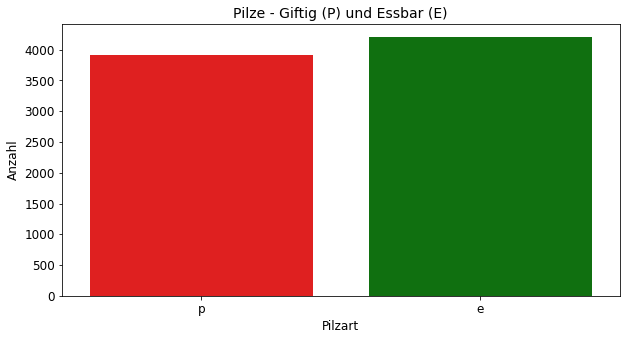

In [7]:
plt.figure(figsize=(10,5))
plt.title('Pilze - Giftig (P) und Essbar (E)', fontsize=14)
sns.countplot(x="class", data=mush, palette=('red','green'))
plt.xlabel("Pilzart", fontsize=12)
plt.ylabel("Anzahl", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

## Data preparation for modelling

In [8]:
# nicht notwendige Klassen weglassen
mush.nunique()

class                        2
cap-shape                    6
cap-surface                  4
cap-color                   10
bruises                      2
odor                         9
gill-attachment              2
gill-spacing                 2
gill-size                    2
gill-color                  12
stalk-shape                  2
stalk-root                   5
stalk-surface-above-ring     4
stalk-surface-below-ring     4
stalk-color-above-ring       9
stalk-color-below-ring       9
veil-type                    1
veil-color                   4
ring-number                  3
ring-type                    5
spore-print-color            9
population                   6
habitat                      7
dtype: int64

In [9]:
mush.drop(columns=['veil-type'], axis=1, inplace=True)

In [10]:
# Labels in den Klassen in integers transformieren (codieren der target labels mit Zahlen zwischen 0 und n_classes-1)
def Label_enc(feature):
    LE = LabelEncoder()
    LE.fit(feature)
    print(feature.name,LE.classes_)
    return LE.transform(feature)

for col in mush.columns:
    mush[str(col)] = Label_enc(mush[str(col)])

class ['e' 'p']
cap-shape ['b' 'c' 'f' 'k' 's' 'x']
cap-surface ['f' 'g' 's' 'y']
cap-color ['b' 'c' 'e' 'g' 'n' 'p' 'r' 'u' 'w' 'y']
bruises ['f' 't']
odor ['a' 'c' 'f' 'l' 'm' 'n' 'p' 's' 'y']
gill-attachment ['a' 'f']
gill-spacing ['c' 'w']
gill-size ['b' 'n']
gill-color ['b' 'e' 'g' 'h' 'k' 'n' 'o' 'p' 'r' 'u' 'w' 'y']
stalk-shape ['e' 't']
stalk-root ['?' 'b' 'c' 'e' 'r']
stalk-surface-above-ring ['f' 'k' 's' 'y']
stalk-surface-below-ring ['f' 'k' 's' 'y']
stalk-color-above-ring ['b' 'c' 'e' 'g' 'n' 'o' 'p' 'w' 'y']
stalk-color-below-ring ['b' 'c' 'e' 'g' 'n' 'o' 'p' 'w' 'y']
veil-color ['n' 'o' 'w' 'y']
ring-number ['n' 'o' 't']
ring-type ['e' 'f' 'l' 'n' 'p']
spore-print-color ['b' 'h' 'k' 'n' 'o' 'r' 'u' 'w' 'y']
population ['a' 'c' 'n' 's' 'v' 'y']
habitat ['d' 'g' 'l' 'm' 'p' 'u' 'w']


# Modellierung

* abhängige Variable: class (essbar oder giftig?)
* unabhängige Variablen (Rest)
* Teilung 70% Training, 30% Test

In [11]:
x = mush.drop(columns=['class'], axis=1)
y = mush['class']

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=0)

## Logistische Regression

In [13]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(class_weight= 'balanced', solver='saga')
logreg.fit(X_train, y_train)
# Vorhersage für Testdaten
y_pred_lr = logreg.predict(X_test)

In [14]:
cmlr=confusion_matrix(y_test,y_pred_lr)
pd.crosstab(y_test, y_pred_lr, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1224,48,1272
1,74,1092,1166
All,1298,1140,2438


In [15]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_lr))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      1272
           1       0.96      0.94      0.95      1166

    accuracy                           0.95      2438
   macro avg       0.95      0.95      0.95      2438
weighted avg       0.95      0.95      0.95      2438



In [16]:
print('Accuracy of logistic regression classifier on test set: {}'.format(logreg.score(X_test, y_test)))

Accuracy of logistic regression classifier on test set: 0.9499589827727646


## Random Forest

In [17]:
model = RandomForestClassifier(n_estimators=10, criterion = 'gini', bootstrap = True, random_state=1)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=10, random_state=1)

In [18]:
y_pred_rf = model.predict(X_test)

In [19]:
cmrf=confusion_matrix(y_test,y_pred_rf)
pd.crosstab(y_test, y_pred_rf, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted,0,1,All
True,,,
0,1272,0,1272
1,0,1166,1166
All,1272,1166,2438


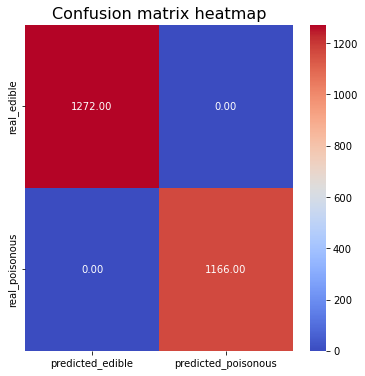

In [20]:
plt.figure(figsize=(6, 6))
x_axis_labels = ['predicted_edible', 'predicted_poisonous'] # labels for x-axis
y_axis_labels = ['real_edible', 'real_poisonous'] # labels for y-axis
sns.heatmap(cmrf, annot=True, xticklabels=x_axis_labels, yticklabels=y_axis_labels, fmt=".2f", cmap='coolwarm')
plt.title("Confusion matrix heatmap", fontsize=16)
plt.show()

In [21]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred_rf))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1272
           1       1.00      1.00      1.00      1166

    accuracy                           1.00      2438
   macro avg       1.00      1.00      1.00      2438
weighted avg       1.00      1.00      1.00      2438



## Random Forest Merkmalsselektion

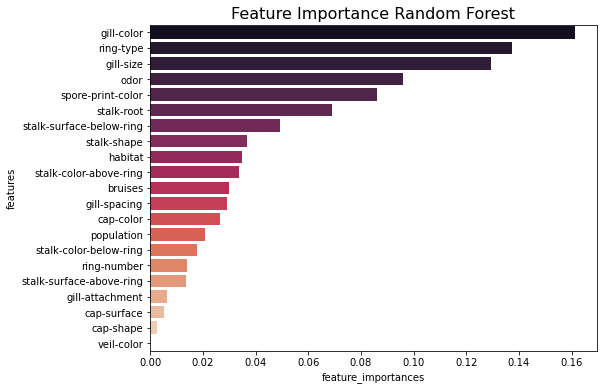

In [22]:
fi_df = pd.DataFrame({
    "feature_importances" : model.feature_importances_,
    "features" : x.columns
})

fi_df.sort_values(by="feature_importances", ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(x="feature_importances", y="features", data=fi_df, palette="rocket")
plt.title("Feature Importance Random Forest", fontsize=16)
plt.show()

# Vergleich Gradient Boosting vs Random Forest

* n_estimators=10: Anzahl der Bäume bleibt gleich wie im Random Forest
* criterion='friedman_mse': Standardkriterium für Gradient Boosting
* learning_rate=0.1: Bestimmt, wie stark jeder neue Baum Fehler korrigiert

In [23]:
from sklearn.ensemble import GradientBoostingClassifier

# Modell erstellen
model = GradientBoostingClassifier(n_estimators=10, criterion='friedman_mse', learning_rate=0.1, random_state=1)

# Modell trainieren
model.fit(X_train, y_train)

# Vorhersagen auf Testdaten
y_pred = model.predict(X_test)

# Konfusionsmatrix berechnen
cm = confusion_matrix(y_test, y_pred)

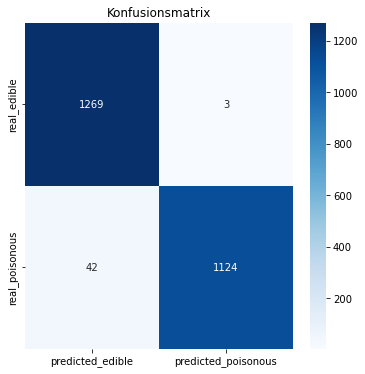

Klassifikationsbericht:
               precision    recall  f1-score   support

           0       0.97      1.00      0.98      1272
           1       1.00      0.96      0.98      1166

    accuracy                           0.98      2438
   macro avg       0.98      0.98      0.98      2438
weighted avg       0.98      0.98      0.98      2438



In [24]:
# Konfusionsmatrix visualisieren
plt.figure(figsize=(6, 6))
plt.xlabel("Vorhergesagte Klassen")
plt.ylabel("Tatsächliche Klassen")
x_axis_labels = ['predicted_edible', 'predicted_poisonous'] # labels for x-axis
y_axis_labels = ['real_edible', 'real_poisonous'] # labels for y-axis
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=x_axis_labels, yticklabels=y_axis_labels)
plt.title("Konfusionsmatrix")
plt.show()

# Klassifikationsbericht ausgeben
print("Klassifikationsbericht:\n", classification_report(y_test, y_pred))

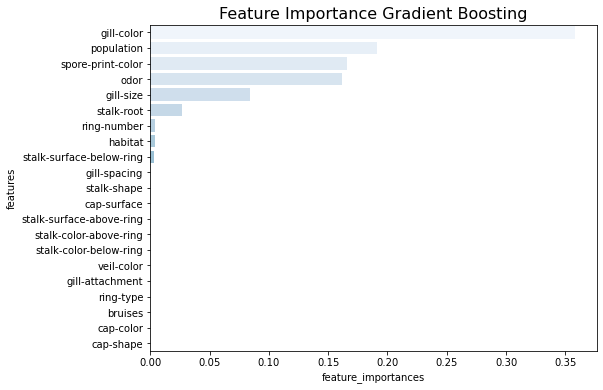

In [25]:
fi_df = pd.DataFrame({
    "feature_importances" : model.feature_importances_,
    "features" : x.columns
})

fi_df.sort_values(by="feature_importances", ascending=False, inplace=True)

plt.figure(figsize=(8,6))
sns.barplot(x="feature_importances", y="features", data=fi_df, palette="Blues")
plt.title("Feature Importance Gradient Boosting", fontsize=16)
plt.show()